<a href="https://colab.research.google.com/github/camlab-bioml/2021_IMC_Jett/blob/main/non_function_version_071421.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.optim as optim
import torch.distributions as D

import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

def _ics(logL, n_obs, n_features, n_clusters): #, n, p, c
  params = ( (((n_features * n_features) - n_features)/2 + 2 * n_features + 3) * (((n_clusters * n_clusters) - n_clusters)/2 + 2 * n_clusters) ) - 1
  return 2 * (params - logL), -2 * logL + params * np.log(n_obs)

In [ ]:
## create data

n_obs = 10000
n_clusters = 3
n_features = 2

## ground true expressions ##
'''
true_expression_means = torch.tensor([
    [1, 2],
    [4, 3],
    [7, 9]
])
'''

true_expression_means = torch.randint(1, 11, (n_clusters, n_features))
print(true_expression_means)

true_expression_covs = torch.tensor([
    [[.01, 0], [0, .01]],
    [[.01, 0], [0, .01]],
    [[.01, 0], [0, .01]]
])

#true_size_means = torch.tensor([.4, .5, .6])
true_size_means = torch.rand(3)
print(true_size_means)

true_size_stds = torch.tensor([.05, .05, .05])
true_size_stds

## other ground true for generating data ##
d_ws = torch.tensor([.95, .05])
z_ws = torch.tensor([1 / 4, 1 / 2, 1 / 4])
g_ws = torch.tensor([0.0667, 0.1333, 0.2000, 0, 0.1000, 0.2667, 0, 0 0.2333])

gs = np.sum(np.random.choice(len(d_ws), size = n_obs, p = d_ws))
zs = n_obs - gs

## simulate data
x = np.zeros((zs, n_features+4))
for i in range(zs):
  z = np.random.choice(n_clusters, size = 1, p = z_ws)[0]
  x[i] = np.append(np.random.multivariate_normal(true_expression_means[z], true_expression_covs[z]), [np.random.normal(true_size_means[z], true_size_stds[z]), 0, z, z+6])
  
xxx = np.zeros((gs, n_features+4))
for i in range(gs):

  g = np.random.choice(6, size = 1, p = g_ws)[0]
    
  if g == 0:
    idx = [0,0]
  elif g == 1:
    idx = [0,1]
  elif g == 2:
    idx = [0,2]
  elif g == 3:
    idx = [1,1]
  elif g == 4:
    idx = [1,2]
  else:
    idx = [2,2]
  
  xxx[i] = np.append(np.random.multivariate_normal( (true_expression_means[idx[0]] + true_expression_means[idx[1]]), (true_expression_covs[idx[0]] + true_expression_covs[idx[1]]) ),
                     [np.random.normal( (true_size_means[idx[0]] + true_size_means[idx[1]]), (true_size_stds[idx[0]] + true_size_stds[idx[1]]) ), 1, g, g])
  
xx = np.append(x, xxx).reshape(n_obs,6)

In [54]:
## initialization

n_obs = N
n_features = 2
n_clusters = 3

#torch.manual_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

emu_c = torch.tensor([
    [1, 2], # 1 2
    [4, 3], # 4 3
    [7, 9]
]) #, requires_grad=True, dtype=torch.float, device=device)

smu_c = torch.tensor([.4, .5, .6]) #, requires_grad=True, dtype=torch.float, device=device)

eco_c = 0.05 * torch.eye(n_features).tile(n_clusters, 1, 1)
sco_c = 0.05 * torch.ones(n_clusters, dtype=torch.float)

smu_cc = torch.zeros(n_clusters, n_clusters)
sco_cc = torch.zeros(n_clusters, n_clusters)

emu_cc = torch.zeros(n_clusters, n_clusters, n_features)
eco_cc = torch.zeros(n_clusters, n_clusters, n_features, n_features)

for j in range(n_clusters):
  for k in range(n_clusters):
    smu_cc[j,k] = smu_c[j] + smu_c[k]
    sco_cc[j,k] = sco_c[j] + sco_c[k]

    emu_cc[j,k] = (emu_c[j] + emu_c[k])
    eco_cc[j,k] = (eco_c[j] + eco_c[k])

#smu_c = torch.tensor(smu_c, requires_grad=True, dtype=torch.float, device=device)
#sco_c = torch.tensor(sco_c, requires_grad=True, dtype=torch.float, device=device)

#emu_c = torch.tensor(emu_c, requires_grad=True, dtype=torch.float, device=device)
#eco_c = torch.tensor(eco_c, requires_grad=True, dtype=torch.float, device=device)

#smu_cc = torch.tensor(smu_cc, requires_grad=True, dtype=torch.float, device=device)
#sco_cc = torch.tensor(sco_cc, requires_grad=True, dtype=torch.float, device=device)

#emu_cc = torch.tensor(emu_cc, requires_grad=True, dtype=torch.float, device=device)
#eco_cc = torch.tensor(eco_cc, requires_grad=True, dtype=torch.float, device=device)

####

pi_d0 = torch.tensor(0.9)

pi_c = torch.empty(n_clusters).fill_(1. / (n_clusters))

pi_cc = torch.triu(torch.ones(n_clusters, n_clusters))
pi_cc = pi_cc / torch.sum(pi_cc)
pi_cc[pi_cc == 0] = float('NaN')

In [49]:
## helper function
def _estimate_mean_cov_t1v1(X, S, r_ij, reg=1e-6):

  #n, p = X.shape
  #n, c = r_ij.shape

  smut = torch.zeros(n_clusters)
  scot = torch.zeros(n_clusters)

  emut = torch.zeros(n_clusters, n_features)
  ecot = torch.zeros(n_clusters, n_features, n_features)

  n_c = torch.sum(r_ij, dim=0) #+ reg # (c)

  for j in range(n_clusters):
    e_n = torch.round(n_c[j])
    idx = r_ij[:,j].argsort()[-e_n.int():]
    smut[j] = torch.mean(S[idx], 0)
    emut[j] = torch.mean(X[idx], 0)
    if e_n > 1:
      ecot[j] = torch.tensor(np.cov(X[idx].T, ddof=0)) + reg * torch.eye(n_features)
      scot[j] = torch.std(S[idx]) + reg
    else:
      ecot[j] = reg * torch.eye(n_features)
      scot[j] = reg
  return n_c, smut, scot, emut, ecot


def _estimate_mean_cov_t2v1(X, S, r_ijk, reg=1e-6):

  #n, p = X.shape
  #n, c, c = r_ijk.shape

  smut = torch.zeros(n_clusters, n_clusters)
  scot = torch.zeros(n_clusters, n_clusters)

  emut = torch.zeros(n_clusters, n_clusters, n_features)
  ecot = torch.zeros(n_clusters, n_clusters, n_features, n_features)

  n_cc = torch.sum(r_ijk, dim=0) #+ reg # (cxc)

  for j in range(n_clusters):
    for k in range(n_clusters):
      if not torch.isnan(n_cc[j,k]):
        e_n = torch.round(n_cc[j,k])
        idx = r_ijk[:,j,k].argsort()[-e_n.int():]
        smut[j,k] = torch.mean(S[idx], 0)
        emut[j,k] = torch.mean(X[idx], 0)
        if e_n > 1:
          scot[j,k] = torch.std(S[idx]) + reg
          ecot[j,k] = torch.tensor(np.cov(X[idx].T, ddof=0)) + reg * torch.eye(n_features)
        else:
          scot[j,k] = reg
          ecot[j,k] = reg * torch.eye(n_features)
  return n_cc, smut, scot, emut, ecot

In [50]:
X = torch.tensor(xx[:,:2])
S = torch.tensor(xx[:,2])

## analytical version 1
n_epochs = 1000
tot = 1e-4
iter = 0
llv = [0.0]

while iter < n_epochs:

  log_pi_d0 = torch.log(pi_d0)
  log_pi_d1 = torch.log(1 - pi_d0)

  log_pi_c = torch.log(pi_c)
  log_pi_cc = torch.log(pi_cc)

  ### E-step:
  log_post_top0 = torch.zeros(n_clusters, n_obs)
  log_post_top1 = torch.zeros(n_clusters, n_clusters, n_obs)

  for j in range(n_clusters):
  
    el0 = D.MultivariateNormal(emu_c[j], eco_c[j]).log_prob(X.float())
    sl0 = D.Normal(smu_c[j], sco_c[j]).log_prob(S.float())
    log_post_top0[j] = log_pi_d0 + log_pi_c[j] + el0 + sl0
    
    for k in range(n_clusters):
      el1 = D.MultivariateNormal((emu_c[j] + emu_c[k])/2, (eco_c[j] + eco_c[k])/2).log_prob(X.float())
      sl1 = D.Normal(smu_c[j] + smu_c[k], sco_c[j] + sco_c[k]).log_prob(S.float())
      #https://stats.stackexchange.com/questions/99363/mean-of-covariance-matrices
      #https://stats.stackexchange.com/questions/214174/calculating-the-covariance-matrix-for-the-mean-of-variables

      if torch.isnan(pi_cc[j,k]): #lower triangular nan
        #log_post_top1[j,k] = float("-Inf")
        log_post_top1[j,k] = float("NaN")
      else:
        log_post_top1[j,k] = log_pi_d1 + log_pi_cc[j,k] + el1 + sl1

  log_post_top1 = log_post_top1.reshape(n_clusters * n_clusters, n_obs) #reshape
  
  ignored_indices = torch.isnan(torch.logsumexp(log_post_top1, 1))
  assert(ignored_indices.sum() == (n_clusters * n_clusters - n_clusters) / 2)

  log_post_tot = torch.logsumexp(torch.vstack((log_post_top0, log_post_top1[~ignored_indices])),0)
  loss = -torch.mean(log_post_tot)

  log_post_bot0 = torch.logsumexp(log_post_top0, 0) #n
  log_post_z = (log_post_top0 - log_post_bot0).T #nxc (rjk)

  log_post_bot1 = torch.logsumexp(log_post_top1[~ignored_indices], 0) #n
  log_post_g = (log_post_top1 - log_post_bot1).T #nx(cxc) (rijk)

  log_post_d0 = log_post_bot0 - log_post_tot
  log_post_d1 = log_post_bot1 - log_post_tot

  log_post_dz = log_post_d0[:,None] + log_post_z
  log_post_dg = log_post_d1[:,None] + log_post_g

  ### M-step:
  pi_d0 = torch.exp(torch.logsumexp(log_post_d0, 0)) / n_obs

  r_ij = torch.exp(log_post_dz)
  n_c, smu_c, sco_c, emu_c, eco_c = _estimate_mean_cov_t1v1(X, S, r_ij)
  pi_c = n_c / n_obs

  r_ijk = torch.exp(log_post_dg).reshape(n_obs, n_clusters, n_clusters)
  n_cc, smu_cc, sco_cc, emu_cc, eco_cc = _estimate_mean_cov_t2v1(X, S, r_ijk)
  pi_cc = n_cc / n_obs
      
  print('Iteration', iter + 1, 'Likelihood: ', -loss, pi_d0)

  if abs(llv[-1] + loss) < tot:
    break
      
  llv.append(-loss)
  iter += 1
  
aic, bic = _ics(-loss, n_obs, n_features, n_clusters)
#return llv[1:], aic, bic

Iteration 1 Likelihood:  tensor(-19.5002) tensor(0.9472)
Iteration 2 Likelihood:  tensor(-39.4023) tensor(0.9478)
Iteration 3 Likelihood:  tensor(-28.0840) tensor(0.9478)
Iteration 4 Likelihood:  tensor(-28.0838) tensor(0.9478)
Iteration 5 Likelihood:  tensor(-28.0838) tensor(0.9478)


In [26]:
pi_d0

tensor(0.9502)

In [27]:
pi_c

tensor([0.2389, 0.4748, 0.2365])

In [28]:
pi_cc

tensor([[6.2797e-14, 2.2858e-03, 5.2973e-04],
        [       nan, 4.5988e-16, 1.3684e-02],
        [       nan,        nan, 3.3310e-02]])

In [29]:
## check number of points in each cluster
for i in range(9):
  print(sum(xx[:,5] == i)/N)

0.0028
0.0077
0.0112
0.006
0.0115
0.0116
0.2389
0.4748
0.2355


In [30]:
bic

tensor(702.3376)

In [31]:
emu_c

tensor([[0.9993, 1.9981],
        [4.0007, 3.0024],
        [7.0055, 9.0083]])

In [91]:
def _estimate_mean_cov_t1v2(X, S, log_rij, reg=1e-6):

  n_obs, n_features = X.shape
  n_obs, n_clusters = log_rij.shape

  smut = torch.zeros(n_clusters)
  scot = torch.zeros(n_clusters)

  emut = torch.zeros(n_clusters, n_features)
  ecot = torch.zeros(n_clusters, n_features, n_features)

  #n_c = torch.sum(r_ij, dim=0) + reg # (c)

  log_n_c = torch.logsumexp(log_rij, dim=0)
  #n_c = torch.exp(log_n_c) + reg

  for j in range(n_clusters):
    e_n = torch.round(torch.exp(log_n_c[j]))
    idx = torch.exp(log_rij[:,j]).argsort()[-e_n.int():]
    smut[j] = torch.mean(S[idx], 0)
    emut[j] = torch.mean(X[idx], 0)
    if e_n > 1:
      ecot[j] = torch.tensor(np.cov(X[idx].T, ddof=0)) + reg * torch.eye(n_features)
      scot[j] = torch.std(S[idx]) + reg
    else:
      ecot[j] = reg * torch.eye(n_features)
      scot[j] = reg
  return log_n_c, smut, scot, emut, ecot

def _estimate_mean_cov_t2v2(X, S, log_rijk, reg=1e-6):

  n_obs, n_features = X.shape
  n_obs, n_clusters, n_clusters = log_rijk.shape

  smut = torch.zeros(n_clusters, n_clusters)
  scot = torch.zeros(n_clusters, n_clusters)

  emut = torch.zeros(n_clusters, n_clusters, n_features)
  ecot = torch.zeros(n_clusters, n_clusters, n_features, n_features)

  #n_cc = torch.sum(r_ijk, dim=0) + reg # (cxc)
  log_n_cc = torch.logsumexp(log_rijk, dim=0) # (cxc)
  #n_cc = torch.exp(log_n_cc) + reg

  for j in range(n_clusters):
    for k in range(n_clusters):
      if not torch.isnan(torch.exp(log_n_cc[j,k])):
        e_n = torch.round(torch.exp(log_n_cc[j,k]))
        idx = torch.exp(log_rijk[:,j,k]).argsort()[-e_n.int():]
        smut[j,k] = torch.mean(S[idx], 0)
        emut[j,k] = torch.mean(X[idx], 0)
        if e_n > 1:
          scot[j,k] = torch.std(S[idx]) + reg
          ecot[j,k] = torch.tensor(np.cov(X[idx].T, ddof=0)) + reg * torch.eye(n_features)
        else:
          scot[j,k] = reg
          ecot[j,k] = reg * torch.eye(n_features)
  return log_n_cc, smut, scot, emut, ecot

In [55]:
X = torch.tensor(xx[:,:2])
S = torch.tensor(xx[:,2])

## analytical version 2
n_epochs = 1000
tot = 1e-4
iter = 0
llv = [0.0]

log_pi_d0 = torch.log(pi_d0)
log_pi_d1 = torch.log(1 - pi_d0)

log_pi_c = torch.log(pi_c)
log_pi_cc = torch.log(pi_cc)

while iter < n_epochs:

  ### E-step:
  log_post_top0 = torch.zeros(n_clusters, n_obs)
  log_post_top1 = torch.zeros(n_clusters, n_clusters, n_obs)

  for j in range(n_clusters):
  
    el0 = D.MultivariateNormal(emu_c[j], eco_c[j]).log_prob(X.float())
    sl0 = D.Normal(smu_c[j], sco_c[j]).log_prob(S.float())
    log_post_top0[j] = log_pi_d0 + log_pi_c[j] + el0 + sl0
    
    for k in range(n_clusters):
      el1 = D.MultivariateNormal((emu_c[j] + emu_c[k])/2, (eco_c[j] + eco_c[k])/2).log_prob(X.float())
      sl1 = D.Normal(smu_c[j] + smu_c[k], sco_c[j] + sco_c[k]).log_prob(S.float())
      #https://stats.stackexchange.com/questions/99363/mean-of-covariance-matrices
      #https://stats.stackexchange.com/questions/214174/calculating-the-covariance-matrix-for-the-mean-of-variables

      if torch.isnan(pi_cc[j,k]): #lower triangular nan
        log_post_top1[j,k] = float("NaN")
      else:
        log_post_top1[j,k] = log_pi_d1 + log_pi_cc[j,k] + el1 + sl1

  log_post_top1 = log_post_top1.reshape(n_clusters * n_clusters, n_obs) #reshape

  ## make sure lower triangular matrix is NaN (a doublet can only be assigned to cluster 1 and 2 not 2 and 1, imposed ordering)
  ignored_indices = torch.isnan(torch.logsumexp(log_post_top1, 1))
  assert(ignored_indices.sum() == (n_clusters * n_clusters - n_clusters) / 2)

  log_post_tot = torch.logsumexp(torch.vstack((log_post_top0, log_post_top1[~ignored_indices])),0)
  loss = -torch.mean(log_post_tot)

  log_post_bot0 = torch.logsumexp(log_post_top0, 0) #n
  log_post_z = (log_post_top0 - log_post_bot0).T #nxc (rjk)

  log_post_bot1 = torch.logsumexp(log_post_top1[~ignored_indices], 0) #n
  log_post_g = (log_post_top1 - log_post_bot1).T #nx(cxc) (rijk)

  log_post_d0 = log_post_bot0 - log_post_tot
  log_post_d1 = log_post_bot1 - log_post_tot

  log_post_dz = log_post_d0[:,None] + log_post_z
  log_post_dg = log_post_d1[:,None] + log_post_g

  ## M-step
  log_n_c, smu_c, sco_c, emu_c, eco_c = _estimate_mean_cov_t1v2(X, S, log_post_dz) 
  log_pi_c = log_n_c - torch.log(torch.tensor(n_obs))
  
  log_n_cc, smu_cc, sco_cc, emu_cc, eco_cc = _estimate_mean_cov_t2v2(X, S, log_post_dg.reshape(n_obs, n_clusters, n_clusters))
  log_pi_cc = log_n_cc - torch.log(torch.tensor(n_obs))

  log_pi_d0 = torch.logsumexp(log_post_d0, 0) - torch.log(torch.tensor(n_obs))
  log_pi_d1 = torch.logsumexp(log_post_d1, 0) - torch.log(torch.tensor(n_obs))

  print('Iteration', iter + 1, 'Likelihood: ', -loss, torch.exp(log_pi_d0))

  if abs(llv[-1] + loss) < tot:
    break
      
  llv.append(-loss)
  iter += 1
  
aic, bic = _ics(-loss, n_obs, n_features, n_clusters)

Iteration 1 Likelihood:  tensor(-19.5002) tensor(0.9472)
Iteration 2 Likelihood:  tensor(-39.4023) tensor(0.9478)
Iteration 3 Likelihood:  tensor(-28.0840) tensor(0.9478)
Iteration 4 Likelihood:  tensor(-28.0838) tensor(0.9478)
Iteration 5 Likelihood:  tensor(-28.0838) tensor(0.9478)


In [56]:
torch.exp(log_pi_d0)

tensor(0.9478)

In [57]:
torch.exp(log_pi_c)

tensor([0.2407, 0.4704, 0.2367])

In [58]:
torch.exp(log_pi_cc)

tensor([[1.7904e-13, 2.5565e-03, 1.1120e-03],
        [       nan, 4.0974e-24, 1.3031e-02],
        [       nan,        nan, 3.5516e-02]])

In [59]:
## check number of points in each cluster
for i in range(9):
  print(sum(xx[:,5] == i)/N)

0.0036
0.0075
0.0095
0.0056
0.0142
0.0124
0.2407
0.4704
0.2361


In [39]:
emu_c

tensor([[0.9993, 1.9981],
        [4.0007, 3.0024],
        [7.0050, 9.0075]])

In [40]:
smu_c

tensor([0.4002, 0.5007, 0.6041])

In [41]:
bic

tensor(704.6602)

In [59]:
X = torch.tensor(xx[:,:2])
S = torch.tensor(xx[:,2])

n_epochs = 1000
tot = 1e-4
iter = 0
llv = [0.0]

while iter < 1:

  log_pi_d0 = torch.log(pi_d0)
  log_pi_d1 = torch.log(1 - pi_d0)

  log_pi_c = torch.log(pi_c)
  log_pi_cc = torch.log(pi_cc)

  ### E-step:
  log_post_top0 = torch.zeros(n_clusters, n_obs)
  log_post_top1 = torch.zeros(n_clusters, n_clusters, n_obs)

  for j in range(n_clusters):
  
    el0 = D.MultivariateNormal(emu_c[j], eco_c[j]).log_prob(X.float())
    sl0 = D.Normal(smu_c[j], sco_c[j]).log_prob(S.float())
    log_post_top0[j] = log_pi_d0 + log_pi_c[j] + el0 + sl0
    
    for k in range(n_clusters):
      el1 = D.MultivariateNormal((emu_c[j] + emu_c[k])/2, (eco_c[j] + eco_c[k])/2).log_prob(X.float())
      sl1 = D.Normal(smu_c[j] + smu_c[k], sco_c[j] + sco_c[k]).log_prob(S.float())
      #https://stats.stackexchange.com/questions/99363/mean-of-covariance-matrices
      #https://stats.stackexchange.com/questions/214174/calculating-the-covariance-matrix-for-the-mean-of-variables

      if torch.isnan(pi_cc[j,k]): #lower triangular nan
        #log_post_top1[j,k] = float("-Inf")
        log_post_top1[j,k] = float("NaN")
      else:
        log_post_top1[j,k] = log_pi_d1 + log_pi_cc[j,k] + el1 + sl1

  iter += 1

log_post_top1 = log_post_top1.reshape(n_clusters * n_clusters, n_obs) #reshape
  
ignored_indices = torch.isnan(torch.logsumexp(log_post_top1, 1))
assert(ignored_indices.sum() == (n_clusters * n_clusters - n_clusters) / 2)

log_post_tot = torch.logsumexp(torch.vstack((log_post_top0, log_post_top1[~ignored_indices])),0)
loss = -torch.mean(log_post_tot)

log_post_bot0 = torch.logsumexp(log_post_top0, 0) #n
log_post_z = (log_post_top0 - log_post_bot0).T #nxc (rjk)

log_post_bot1 = torch.logsumexp(log_post_top1[~ignored_indices], 0) #n
log_post_g = (log_post_top1 - log_post_bot1).T #nx(cxc) (rijk)

log_post_d0 = log_post_bot0 - log_post_tot
log_post_d1 = log_post_bot1 - log_post_tot

log_post_dz = log_post_d0[:,None] + log_post_z
log_post_dg = log_post_d1[:,None] + log_post_g

### M-step:
#log_pi_d0 = torch.logsumexp(log_post_d0, 0) - torch.log(torch.tensor(n_obs))
pi_d0 = torch.exp(torch.logsumexp(log_post_d0, 0)) / n_obs

r_ij = torch.exp(log_post_dz)
n_c, smu_c, sco_c, emu_c, eco_c = _estimate_mean_cov_t1v1(X, S, r_ij)
#log_pi_c = torch.log(n_c) - torch.log(torch.tensor(n_obs))
pi_c = n_c / n_obs

r_ijk = torch.exp(log_post_dg).reshape(n_obs, n_clusters, n_clusters)
n_cc, smu_cc, sco_cc, emu_cc, eco_cc = _estimate_mean_cov_t2v1(X, S, r_ijk)
#log_pi_cc = torch.log(n_cc) - torch.log(torch.tensor(n_obs))
pi_cc = n_cc / n_obs

In [114]:
## initialization

n_obs = N
n_features = 2
n_clusters = 3

#torch.manual_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

emu_c = torch.tensor([
    [2, 4], # 1 2
    [3, 5], # 4 3
    [5, 7] #7 9
], dtype=torch.float) #, requires_grad=True, , device=device)

smu_c = torch.tensor([.3, .4, .5], dtype=torch.float) #, requires_grad=True,  device=device)

eco_c = 0.05 * torch.eye(n_features).tile(n_clusters, 1, 1)
sco_c = 0.05 * torch.ones(n_clusters, dtype=torch.float)

smu_cc = torch.zeros(n_clusters, n_clusters, dtype=torch.float)
sco_cc = torch.zeros(n_clusters, n_clusters, dtype=torch.float)

emu_cc = torch.zeros(n_clusters, n_clusters, n_features, dtype=torch.float)
eco_cc = torch.zeros(n_clusters, n_clusters, n_features, n_features, dtype=torch.float)

for j in range(n_clusters):
  for k in range(n_clusters):
    if k >= j:
      smu_cc[j,k] = smu_c[j] + smu_c[k]
      sco_cc[j,k] = sco_c[j] + sco_c[k]

      emu_cc[j,k] = (emu_c[j] + emu_c[k])
      eco_cc[j,k] = (eco_c[j] + eco_c[k])

smu_c = torch.tensor(smu_c, requires_grad=True, dtype=torch.float, device=device)
sco_c = torch.tensor(sco_c, requires_grad=True, dtype=torch.float, device=device)
      
emu_c = torch.tensor(emu_c, requires_grad=True, dtype=torch.float, device=device)
eco_c = torch.tensor(eco_c, requires_grad=True, dtype=torch.float, device=device)
      
smu_cc = torch.tensor(smu_cc, requires_grad=True, dtype=torch.float, device=device)
sco_cc = torch.tensor(sco_cc, requires_grad=True, dtype=torch.float, device=device)
      
emu_cc = torch.tensor(emu_cc, requires_grad=True, dtype=torch.float, device=device)
eco_cc = torch.tensor(eco_cc, requires_grad=True, dtype=torch.float, device=device)
      
####

pi_d0 = torch.tensor(0.9)

pi_c = torch.empty(n_clusters).fill_(1. / (n_clusters))

pi_cc = torch.triu(torch.ones(n_clusters, n_clusters))
pi_cc = pi_cc / torch.sum(pi_cc)
pi_cc[pi_cc == 0] = float('NaN')

def _ics(logL, n_obs, n_features, n_clusters): #, n, p, c
  params = ( (((n_features * n_features) - n_features)/2 + 2 * n_features + 3) * (((n_clusters * n_clusters) - n_clusters)/2 + 2 * n_clusters) ) - 1
  return 2 * (params - logL), -2 * logL + params * np.log(n_obs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

In [ ]:
## torch.optim version

X = torch.tensor(xx[:,:2])
S = torch.tensor(xx[:,2])

#parameters = [emu_c, eco_c, smu_c, sco_c]
#parameters = [emu_cc, eco_cc, smu_cc, sco_cc]
parameters = [emu_c, eco_c, smu_c, sco_c, emu_cc, eco_cc, smu_cc, sco_cc]
#opt = optim.SGD(parameters, lr=0.01)
opt = optim.Adam(parameters)

tot = 1e-3
llv = [0.0]

log_pi_d0 = torch.log(pi_d0)
log_pi_d1 = torch.log(1-pi_d0)
log_pi_c = torch.log(pi_c)
log_pi_cc = torch.log(pi_cc)

iter = 0
n_epochs = 1000
while iter < n_epochs:

  log_post_top0 = torch.zeros(n_clusters, n_obs)
  log_post_top1 = torch.zeros(n_clusters, n_clusters, n_obs)

  for j in range(n_clusters):  
    el0 = D.MultivariateNormal(emu_c[j], eco_c[j]).log_prob(X.float())
    sl0 = D.Normal(smu_c[j], sco_c[j]).log_prob(S.float())
    log_post_top0[j] = log_pi_d0 + log_pi_c[j] + el0 + sl0

    for k in range(n_clusters):
      el1 = D.MultivariateNormal(emu_cc[j,k]/2, eco_cc[j,k]/2).log_prob(X.float())
      sl1 = D.Normal(smu_cc[j,k], sco_cc[j,k]).log_prob(S.float())
            
      if torch.isnan(pi_cc[j,k]): #lower triangular nan
        log_post_top1[j,k] = float("NaN")
      else:
        log_post_top1[j,k] = log_pi_d1 + log_pi_cc[j,k] + el1 + sl1

  log_post_top1 = log_post_top1.reshape(n_clusters * n_clusters, n_obs) #reshape

  ignored_indices = torch.isnan(torch.logsumexp(log_post_top1, 1))
  assert(ignored_indices.sum() == (n_clusters * n_clusters - n_clusters) / 2)
  
  log_post_tot = torch.logsumexp(torch.vstack((log_post_top0, log_post_top1[~ignored_indices])),0)
  loss = -torch.mean(log_post_tot)

  opt.zero_grad()
  loss.backward()
  opt.step()

  with torch.no_grad():
    parameters[0].clamp_(tot)
    ##parameters[1].clamp_(tot)
    parameters[2].clamp_(tot)
    parameters[3].clamp_(tot)
    parameters[4].clamp_(tot)
    ##parameters[5].clamp_(tot)
    parameters[6].clamp_(tot)
    parameters[7].clamp_(tot)

    eco_c += torch.eye(n_features) * tot
    eco_cc += torch.eye(n_features) * tot

    log_post_bot0 = torch.logsumexp(log_post_top0, 0) #n
    log_post_bot1 = torch.logsumexp(log_post_top1[~ignored_indices], 0) #n
    
    log_post_d0 = log_post_bot0 - log_post_tot
    log_post_d1 = log_post_bot1 - log_post_tot

    log_post_z = (log_post_top0 - log_post_bot0).T #nxc (rjk)
    log_post_g = (log_post_top1 - log_post_bot1).T #nxc (rijk)

    log_post_dz = log_post_d0[:,None] + log_post_z
    log_post_dg = log_post_d1[:,None] + log_post_g

    log_n_c = torch.logsumexp(log_post_dz, 0)
    log_pi_c = log_n_c - torch.log(torch.tensor(n_obs))

    log_n_cc = torch.logsumexp(log_post_dg, 0).reshape(n_clusters, n_clusters)
    log_pi_cc = log_n_cc - torch.log(torch.tensor(n_obs))  # cxc matrix

    log_pi_d0 = torch.logsumexp(log_post_d0, 0) - torch.log(torch.tensor(n_obs))
    log_pi_d1 = torch.logsumexp(log_post_d1, 0) - torch.log(torch.tensor(n_obs))

  print('Iteration', iter + 1, 'Likelihood: ', -loss, torch.exp(log_pi_d0))

  if abs(llv[-1] + loss) < tot:
    break
      
  llv.append(-loss)
  iter += 1

aic, bic = _ics(-loss, n_obs, n_features, n_clusters)

#print(epoch, pi_d0, loss)

In [79]:
torch.exp(log_pi_d0)

tensor(0.9976)

In [80]:
torch.exp(log_pi_c)

tensor([0.2782, 0.4357, 0.2837])

In [81]:
torch.exp(log_pi_cc)

tensor([[0.0024, 0.0000, 0.0000],
        [   nan, 0.0000, 0.0000],
        [   nan,    nan, 0.0000]])

In [82]:
## check number of points in each cluster
for i in range(9):
  print(sum(xx[:,5] == i)/N)

0.0028
0.0077
0.0112
0.006
0.0115
0.0116
0.2389
0.4748
0.2355


In [83]:
emu_c

tensor([[1.7086, 3.6069],
        [3.3877, 4.6038],
        [5.4044, 7.3912]], requires_grad=True)

In [69]:
smu_c

tensor([0.4002, 0.5007, 0.6034], requires_grad=True)

In [70]:
bic

tensor(656.7866, grad_fn=<AddBackward0>)

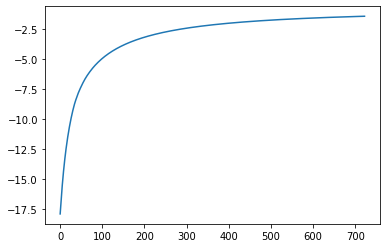

In [71]:
plt.plot(llv[1:])

## The Log-Likelihood:
Typically, we find $\theta$ which maximizes the log-likelihood $\log[P(X|\theta)]$. Assuming independence, it looks like the following:
\begin{align}
\ell(\theta) = \log P(X|\theta)
& = \log P(x_1,...,x_n|\theta) \\
& = \log \prod^n_{i=1} P(x_i|\theta) = \sum^n_{i=1} \log P(x_i|\theta) 
\end{align}

However, we can only compute $P(X,Z|\theta)$ due to the dependency on $Z$, we must marginalize out $Z$ to compute $P(X|\theta)$, then we want to maximize the following log-likelihood:
\begin{align}
\sum^n_{i=1} \log P(x_i|\theta) = \sum^n_{i=1} \log P(x_i|\theta) = \sum^n_{i=1} \log \sum^c_{j=1} P(x_i, z_j|\theta)
\end{align}

This quantity is more difficult to maximize because we have to marginalize or sum over the latent variable $Z$ for all $n$ data points. Therefore, we need to compute a proxy function instead.

## Complete Log-Likelihood:
The complete data log-likelihood is maximized below which at first assumes that for each data point $x_i$ we have a known discrete latent assignment $z_i$.

\begin{align}
\sum^n_{i=1} \log P(x_i, z_i|\theta) = \sum^n_{i=1} \log [P(z_i|\theta)P(x_i|z_i,\theta)]
\end{align}

We no longer have to sum across $Z$ but we don't know $z_i$. Therefore, we try to guess at $z_i$ by maximizing $Q(\theta, \theta^*)$ (i.e., the expectation of the complete log-likelihood with respect to $Z|X,\theta^*$, which allows us to fill in the values of $z_i$

## Computing $Q(\theta, \theta^*)$:

\begin{align}
Q(\theta, \theta^*) 
& = E_{Z|X,\theta^*} [\sum^n_{i=1} \log P(z_i|\theta)P(x_i|z_i,\theta)] \\
& = \sum^n_{i=1} E_{Z|X,\theta^*} [[\log \sum^c_{j=1}[P(z_i=c|\theta)P(x_i|z_i=c,\theta)]^{I(z_i=c)}] \\
& = \sum^n_{i=1} \sum^c_{j=1} P(z_i=c|X,\theta^*)\log[P(z_i=c|\theta)P(x_i|z_i=c,\theta)]
\end{align}

where $I$ is the indicator function and can be used to evaluate the expecation because we assume that $z_i$ is discrete. 

In the equation above, the left-most term is the soft latent assignments and the right-most term is the log product of the prior of $Z$ and the conditional P.M.F. The right-most term can be separated into two terms allowing for the maximization of the mixture weights (prior of $Z$) and the distribution parameters of the P.M.F.

## Expectation-Maximization (EM) Algorithm:
The EM algorithm aims to maximze the expected complete data log-looklihood by interating the following two steps until convergence:
1. Given the parameters $\theta^*$ from the previous iteration, evaluate $Q$ function.
2. Maximize this $Q$ function in terms of $\theta$

## Convergence Proof:
https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm#Proof_of_correctness

https://see.stanford.edu/materials/aimlcs229/cs229-notes8.pdf

## EM for GMM:

\begin{align}
P(x_i|\theta) & = \sum^n_{j=1} P(z_i=c) P(x_i|z_i=c,\theta), \\
& x_i|z_i \sim N(\mu_c, \Sigma_c), \\
& z_i \sim Categorical(\pi).
\end{align}

1. Compute $Q(\theta, \theta^*)$:
\begin{align}
Q(\theta, \theta^*) 
& = \sum^n_{i=1} \sum^c_{j=1} P(z_i=c|x_i,\theta^*)\log[P(z_i=c|\theta)P(x_i|z_i=c,\theta)] \\
& =  \sum^n_{i=1} \sum^c_{j=1} [r_{ij} \log P(z_i=c|\theta) + r_{ij} \log P(x_i|z_i=c,\theta)] \\
& = \sum^n_{i=1} \sum^c_{j=1} [r_{ij} \log \pi_{j} + r_{ij} \log N(x_i; \mu_j, \Sigma_j)]
\end{align}

2. Update $\theta^t = argmax (\theta, \theta^*) = (\pi^t, \mu^t, \Sigma^t)$:

The $Q$ function is like a weighted normal distribution MLE problem, we could maximize $\theta$ by differentiating the formula above and provide closed-form formulas.

\begin{align}
Q(\theta, \theta^*) 
& = \sum^n_{i=1} \sum^c_{j=1} r_{ij} [\log \pi_{j} + \log N(x_i; \mu_j, \Sigma_j)] \\
& \implies r_{ij} [\log \pi_j + \frac{1}{2}\log(|\Sigma_{j}|^{-1}) -
    \frac{1}{2}(y_i-\mu_j)^T\Sigma^{-1}_{j}(y_i-\mu_j) + constant] \\
\end{align}

then we differentiate the forumula for each cluster c,

$\pi^{t}_j = \frac{\sum r^{(t-1)}_{ij}}{n}$, which was applied lagrangian multiplier to solve $w_j$.

$\mu^{t}_j = \frac{\sum r^{(t-1)}_{ij} y_i} {\sum r^{(t-1)}_{ij}}$, which was solved by taking MLE of $\mu_j$.

$\Sigma^{t}_j = \frac{\sum r^{(t-1)}_{ij} (y_i - \mu^{(t-1)}_j) (y_i - \mu^{(t-1)}_j)^T} {\sum z^{(t-1)}_{ij}}$, which was solved by MLE of $\Sigma_j$.


## EM for Doublet Gaussian Mixutre Model (DGMM):

\begin{align}
P(y_i, s_i|\theta) 
= & \sum^n_{i=1} [P(d_i=0) P(z_i=c) P(y_i|z_i=c,\theta) P(s_i|z_i=c,\theta) \\
& + P(d_i=1) P(\gamma_i=[c,c']) P(y_i|\gamma_i=[c,c'],\theta) P(s_i|\gamma_i=[c,c'],\theta)], \\
& d_i \sim Bernoulli(p), \\
& z_i \sim Categorical(\pi_c), \\
& \gamma_i \sim Categorical(\pi_{cxc}), \\
& y_i|z_i \sim N(\mu_c, \Sigma_c), \\ 
& s_i|z_i \sim N(\psi_c, \omega_c), \\
& y_i|\gamma_i=[c,c'] \sim N((\mu_{c_j} + \mu_{c_k})/2, (\Sigma_{c_j} + \Sigma_{c_k})/2), \\
& s_i|\gamma_i=[c,c'] \sim N(\psi_{c_j} + \psi_{c_k} , \omega_{c_j} + \omega_{c_k}).
\end{align}



In [9]:
import torch
import torch.optim as optim
import torch.distributions as D

import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

def _ics(logL, n_obs, n_features, n_clusters): #, n, p, c
  params = ( (((n_features * n_features) - n_features)/2 + 2 * n_features + 3) * (((n_clusters * n_clusters) - n_clusters)/2 + 2 * n_clusters) ) - 1
  return 2 * (params - logL), -2 * logL + params * np.log(n_obs)

In [10]:
def _estimate_mean_cov_t1v2(X, S, log_rij, reg=1e-6):

  n_obs, n_features = X.shape
  n_obs, n_clusters = log_rij.shape

  smut = torch.zeros(n_clusters)
  scot = torch.zeros(n_clusters)

  emut = torch.zeros(n_clusters, n_features)
  ecot = torch.zeros(n_clusters, n_features, n_features)

  #n_c = torch.sum(r_ij, dim=0) + reg # (c)

  log_n_c = torch.logsumexp(log_rij, dim=0)
  #n_c = torch.exp(log_n_c) + reg

  for j in range(n_clusters):
    e_n = torch.round(torch.exp(log_n_c[j]))
    idx = torch.exp(log_rij[:,j]).argsort()[-e_n.int():]
    smut[j] = torch.mean(S[idx], 0)
    emut[j] = torch.mean(X[idx], 0)
    if e_n > 1:
      ecot[j] = torch.tensor(np.cov(X[idx].T, ddof=0)) + reg * torch.eye(n_features)
      scot[j] = torch.std(S[idx]) + reg
    else:
      ecot[j] = reg * torch.eye(n_features)
      scot[j] = reg
  return log_n_c, smut, scot, emut, ecot

def _estimate_mean_cov_t2v2(X, S, log_rijk, reg=1e-6):

  n_obs, n_features = X.shape
  n_obs, n_clusters, n_clusters = log_rijk.shape

  smut = torch.zeros(n_clusters, n_clusters)
  scot = torch.zeros(n_clusters, n_clusters)

  emut = torch.zeros(n_clusters, n_clusters, n_features)
  ecot = torch.zeros(n_clusters, n_clusters, n_features, n_features)

  #n_cc = torch.sum(r_ijk, dim=0) + reg # (cxc)
  log_n_cc = torch.logsumexp(log_rijk, dim=0) # (cxc)
  #n_cc = torch.exp(log_n_cc) + reg

  for j in range(n_clusters):
    for k in range(n_clusters):
      if not torch.isnan(torch.exp(log_n_cc[j,k])):
        e_n = torch.round(torch.exp(log_n_cc[j,k]))
        idx = torch.exp(log_rijk[:,j,k]).argsort()[-e_n.int():]
        smut[j,k] = torch.mean(S[idx], 0)
        emut[j,k] = torch.mean(X[idx], 0)
        if e_n > 1:
          scot[j,k] = torch.std(S[idx]) + reg
          ecot[j,k] = torch.tensor(np.cov(X[idx].T, ddof=0)) + reg * torch.eye(n_features)
        else:
          scot[j,k] = reg
          ecot[j,k] = reg * torch.eye(n_features)
  return log_n_cc, smut, scot, emut, ecot

In [11]:
## analytical version (function)
def em_v1(X, S, hyperparameters, parameters, n_epochs = 1000, tot = 1e-6):
  
  n_obs, n_features = X.shape
  n_clusters = len(hyperparameters[1])

  log_pi_d0 = torch.log(hyperparameters[0])
  log_pi_d1 = torch.log(1-hyperparameters[0])
  log_pi_c = torch.log(hyperparameters[1])
  log_pi_cc = torch.log(hyperparameters[2])

  emu_c = parameters[0]
  eco_c = parameters[1]
  smu_c = parameters[2]
  sco_c = parameters[3]

  emu_cc = parameters[4]
  eco_cc = parameters[5]
  smu_cc = parameters[6]
  sco_cc = parameters[7]

  iter = 0
  llv = [0.0]
  while iter < n_epochs:

    ### E-step:
    log_post_top0 = torch.zeros(n_clusters, n_obs)
    log_post_top1 = torch.zeros(n_clusters, n_clusters, n_obs)

    for j in range(n_clusters):
  
      el0 = D.MultivariateNormal(emu_c[j], eco_c[j]).log_prob(X.float())
      sl0 = D.Normal(smu_c[j], sco_c[j]).log_prob(S.float())

      log_post_top0[j] = log_pi_d0 + log_pi_c[j] + el0 + sl0
    
      for k in range(n_clusters):
        if torch.isnan(log_pi_cc[j,k]): #lower triangular nan
          log_post_top1[j,k] = float("NaN")
        else:
          el1 = D.MultivariateNormal((emu_c[j] + emu_c[k])/2, (eco_c[j] + eco_c[k])/2).log_prob(X.float())
          sl1 = D.Normal(smu_c[j] + smu_c[k], sco_c[j] + sco_c[k]).log_prob(S.float())
          log_post_top1[j,k] = log_pi_d1 + log_pi_cc[j,k] + el1 + sl1

          #https://stats.stackexchange.com/questions/99363/mean-of-covariance-matrices
          #https://stats.stackexchange.com/questions/214174/calculating-the-covariance-matrix-for-the-mean-of-variables

    log_post_top1 = log_post_top1.reshape(n_clusters * n_clusters, n_obs) #reshape

    ## make sure lower triangular matrix is NaN (a doublet can only be assigned to cluster 1 and 2 not 2 and 1, imposed ordering)
    ignored_indices = torch.isnan(torch.logsumexp(log_post_top1, 1))
    assert(ignored_indices.sum() == (n_clusters * n_clusters - n_clusters) / 2)

    log_post_tot = torch.logsumexp(torch.vstack((log_post_top0, log_post_top1[~ignored_indices])),0)
    loss = -torch.mean(log_post_tot)

    log_post_bot0 = torch.logsumexp(log_post_top0, 0) #n
    log_post_z = (log_post_top0 - log_post_bot0).T #nxc (rjk)

    log_post_bot1 = torch.logsumexp(log_post_top1[~ignored_indices], 0) #n
    log_post_g = (log_post_top1 - log_post_bot1).T #nx(cxc) (rijk)

    log_post_d0 = log_post_bot0 - log_post_tot
    log_post_d1 = log_post_bot1 - log_post_tot

    log_post_dz = log_post_d0[:,None] + log_post_z
    log_post_dg = log_post_d1[:,None] + log_post_g

    ## M-step
    log_n_c, smu_c, sco_c, emu_c, eco_c = _estimate_mean_cov_t1v2(X, S, log_post_dz)
    log_pi_c = log_n_c - torch.log(torch.tensor(n_obs))
  
    log_n_cc, smu_cc, sco_cc, emu_cc, eco_cc = _estimate_mean_cov_t2v2(X, S, log_post_dg.reshape(n_obs, n_clusters, n_clusters))
    log_pi_cc = log_n_cc - torch.log(torch.tensor(n_obs))

    log_pi_d0 = torch.logsumexp(log_post_d0, 0) - torch.log(torch.tensor(n_obs))
    log_pi_d1 = torch.logsumexp(log_post_d1, 0) - torch.log(torch.tensor(n_obs))

    if abs(llv[-1] + loss) < tot:
      break
      
    llv.append(-loss)
    iter += 1

  aic, bic = _ics(-loss, n_obs, n_features, n_clusters)
  #print('Iteration', iter + 1, 'Likelihood: ', -loss, torch.exp(log_pi_d0), aic, bic)
  print('Version 1', -loss, torch.exp(log_pi_d0), aic, bic)

  out_hyperparams = [torch.exp(log_pi_d0), torch.exp(log_pi_c), torch.exp(log_pi_cc)]
  out_params = [smu_c, sco_c, emu_c, eco_c, smu_cc, sco_cc, emu_cc, eco_cc]
  return llv[1:], aic, bic, out_hyperparams, parameters

In [12]:
## torch.optim version (function)
def em_v2(X, S, hyperparameters, parameters, n_epochs = 1000, tot = 1e-4):

  n_obs, n_features = X.shape
  n_clusters = len(hyperparameters[1])

  log_pi_d0 = torch.log(hyperparameters[0])
  log_pi_d1 = torch.log(1-hyperparameters[0])
  log_pi_c = torch.log(hyperparameters[1])
  log_pi_cc = torch.log(hyperparameters[2])

  #opt = optim.SGD(parameters, lr=0.01)
  opt = optim.Adam(parameters, lr=0.01)

  iter = 0
  llv = [0.0]
  while iter < n_epochs:

    log_post_top0 = torch.zeros(n_clusters, n_obs)
    log_post_top1 = torch.zeros(n_clusters, n_clusters, n_obs)

    for j in range(n_clusters):  
      #el0 = D.MultivariateNormal(emu_c[j], eco_c[j]).log_prob(X.float())
      #sl0 = D.Normal(smu_c[j], sco_c[j]).log_prob(S.float())

      el0 = D.MultivariateNormal(parameters[0][j], parameters[1][j]).log_prob(X.float())
      sl0 = D.Normal(parameters[2][j], parameters[3][j]).log_prob(S.float())

      log_post_top0[j] = log_pi_d0 + log_pi_c[j] + el0 + sl0

      for k in range(n_clusters):
        if torch.isnan(log_pi_cc[j,k]): #lower triangular nan
          log_post_top1[j,k] = float("NaN")
        else:
          #el1 = D.MultivariateNormal(emu_cc[j,k]/2, eco_cc[j,k]/2).log_prob(X.float())
          #sl1 = D.Normal(smu_cc[j,k], sco_cc[j,k]).log_prob(S.float())
        
          el1 = D.MultivariateNormal(parameters[4][j,k], parameters[5][j,k]).log_prob(X.float())
          sl1 = D.Normal(parameters[6][j,k], parameters[7][j,k]).log_prob(S.float())
          log_post_top1[j,k] = log_pi_d1 + log_pi_cc[j,k] + el1 + sl1

    log_post_top1 = log_post_top1.reshape(n_clusters * n_clusters, n_obs) #reshape
    
    ignored_indices = torch.isnan(torch.logsumexp(log_post_top1, 1))
    assert(ignored_indices.sum() == (n_clusters * n_clusters - n_clusters) / 2)
  
    log_post_tot = torch.logsumexp(torch.vstack((log_post_top0, log_post_top1[~ignored_indices])),0)
    loss = -torch.mean(log_post_tot)

    opt.zero_grad()
    loss.backward()
    opt.step()

    with torch.no_grad():
      parameters[0].clamp_(tot)
      ##parameters[1].clamp_(tot)
      parameters[2].clamp_(tot)
      parameters[3].clamp_(tot)
      parameters[4].clamp_(tot)
      ##parameters[5].clamp_(tot)
      parameters[6].clamp_(tot)
      parameters[7].clamp_(tot)

      parameters[1] += torch.eye(n_features) * 0.01
      parameters[5] += torch.eye(n_features) * 0.01

      log_post_bot0 = torch.logsumexp(log_post_top0, 0) #n
      log_post_bot1 = torch.logsumexp(log_post_top1[~ignored_indices], 0) #n
    
      log_post_d0 = log_post_bot0 - log_post_tot
      log_post_d1 = log_post_bot1 - log_post_tot
      
      log_post_z = (log_post_top0 - log_post_bot0).T #nxc (rjk)
      log_post_g = (log_post_top1 - log_post_bot1).T #nx(cc) (rijk)

      log_post_dz = log_post_d0[:,None] + log_post_z
      log_post_dg = log_post_d1[:,None] + log_post_g

      log_n_c = torch.logsumexp(log_post_dz, 0)
      log_pi_c = log_n_c - torch.log(torch.tensor(n_obs))

      log_n_cc = torch.logsumexp(log_post_dg, 0).reshape(n_clusters, n_clusters)
      log_pi_cc = log_n_cc - torch.log(torch.tensor(n_obs))  # cxc matrix

      log_pi_d0 = torch.logsumexp(log_post_d0, 0) - torch.log(torch.tensor(n_obs))
      log_pi_d1 = torch.logsumexp(log_post_d1, 0) - torch.log(torch.tensor(n_obs))

    if abs(llv[-1] + loss) < tot:
      break
      
    llv.append(-loss)
    iter += 1

  aic, bic = _ics(-loss, n_obs, n_features, n_clusters)
  print('Version 2', -loss, torch.exp(log_pi_d0), aic, bic)

  out_hyperparams = [torch.exp(log_pi_d0), torch.exp(log_pi_c), torch.exp(log_pi_cc)]
  return llv[1:], aic, bic, out_hyperparams, parameters

In [13]:
def generateData(n_clusters = 3, n_obs = 10000, n_features = 2):

  ## set ground true expressions ##

  '''
  true_expression_means = torch.tensor([
      [1, 2],
      [4, 3],
      [7 , 9]
  ])
  '''
  true_expression_means = torch.randint(1, 11, (n_clusters, n_features))
  #print(true_expression_means)

  true_expression_covs = torch.tensor([
      [[.01, 0], [0, .01]],
      [[.01, 0], [0, .01]],
      [[.01, 0], [0, .01]]
  ])

  #true_size_means = torch.tensor([.4, .5, .6])
  true_size_means = torch.rand(n_clusters)
  #print(true_size_means)

  true_size_stds = torch.tensor([.05, .05, .05])
  #true_size_stds

  ## other ground true for generating data ##
  d_ws = torch.tensor([.95, .05])
  
  #z_ws = torch.tensor([1 / 4, 1 / 2, 1 / 4])
  z_ws = np.random.rand(n_clusters)
  z_ws /= z_ws.sum()
  #print(z_ws.sum())

  #g_ws = torch.tensor([0.0667, 0.1333, 0.2000, 0.1000, 0.2667, 0.2333])
  n_events = int((n_clusters * n_clusters - n_clusters)/2 + n_clusters)
  g_ws = np.random.rand(n_events)
  g_ws /= g_ws.sum()
  #print(g_ws.sum())
  
  gs = np.sum(np.random.choice(2, size = n_obs, p = d_ws))
  zs = n_obs - gs

  ## simulate data
  x = np.zeros((zs, n_features+4))
  for i in range(zs):
    z = np.random.choice(n_clusters, size = 1, p = z_ws)[0]
    x[i] = np.append(np.random.multivariate_normal(true_expression_means[z], true_expression_covs[z]), [np.random.normal(true_size_means[z], true_size_stds[z]), 0, z, z+6])
  
  xxx = np.zeros((gs, n_features+4))
  for i in range(gs):

    g = np.random.choice(6, size = 1, p = g_ws)[0]
    
    if g == 0:
      idx = [0,0]
    elif g == 1:
      idx = [0,1]
    elif g == 2:
      idx = [0,2]
    elif g == 3:
      idx = [1,1]
    elif g == 4:
      idx = [1,2]
    else:
      idx = [2,2]
  
    xxx[i] = np.append(np.random.multivariate_normal( (true_expression_means[idx[0]] + true_expression_means[idx[1]]), (true_expression_covs[idx[0]] + true_expression_covs[idx[1]]) ),
                     [np.random.normal( (true_size_means[idx[0]] + true_size_means[idx[1]]), (true_size_stds[idx[0]] + true_size_stds[idx[1]]) ), 1, g, g])
  
  xx = np.append(x, xxx).reshape(n_obs,6)

  return torch.tensor(xx[:,:2]), torch.tensor(xx[:,2])

In [14]:
## initialization
def initialization(n_clusters, X, S):

  n_obs, n_features = X.shape

  #torch.manual_seed(seed_num)

  device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
  #pi_d0 = torch.tensor(0.9)
  pi_d0 = torch.tensor(np.random.uniform(.9, 1))
  
  pi_c = torch.empty(n_clusters).fill_(1. / (n_clusters))
  
  pi_cc = torch.triu(torch.ones(n_clusters, n_clusters))
  pi_cc = pi_cc / torch.sum(pi_cc)
  pi_cc[pi_cc == 0] = float('NaN')

  emu_c = X[np.random.choice(n_obs, n_clusters, replace=False)].float()

  '''
  emu_c = torch.tensor([
    [2, 4], # 1 2
    [3, 5], # 4 3
    [5, 7] #7 9
  ], dtype=torch.float) #, requires_grad=True, , device=device)
  '''

  smu_c = S[np.random.choice(n_obs, n_clusters, replace=False)].float()
  #smu_c = torch.tensor([.3, .4, .5], dtype=torch.float) #, requires_grad=True,  device=device)

  eco_c = 0.05 * torch.eye(n_features).tile(n_clusters, 1, 1)
  sco_c = 0.05 * torch.ones(n_clusters, dtype=torch.float)

  smu_cc = torch.zeros(n_clusters, n_clusters, dtype=torch.float)
  sco_cc = torch.zeros(n_clusters, n_clusters, dtype=torch.float)

  emu_cc = torch.zeros(n_clusters, n_clusters, n_features, dtype=torch.float)
  eco_cc = torch.zeros(n_clusters, n_clusters, n_features, n_features, dtype=torch.float)

  for j in range(n_clusters):
    for k in range(n_clusters):
      if k >= j:
        smu_cc[j,k] = smu_c[j] + smu_c[k]
        sco_cc[j,k] = sco_c[j] + sco_c[k]

        emu_cc[j,k] = (emu_c[j] + emu_c[k])
        eco_cc[j,k] = (eco_c[j] + eco_c[k])

  params1 = [emu_c, eco_c, smu_c, sco_c, emu_cc, eco_cc, smu_cc, sco_cc]

  smu_c = torch.tensor(smu_c, requires_grad=True, dtype=torch.float, device=device)
  sco_c = torch.tensor(sco_c, requires_grad=True, dtype=torch.float, device=device)
      
  emu_c = torch.tensor(emu_c, requires_grad=True, dtype=torch.float, device=device)
  eco_c = torch.tensor(eco_c, requires_grad=True, dtype=torch.float, device=device)
      
  smu_cc = torch.tensor(smu_cc, requires_grad=True, dtype=torch.float, device=device)
  sco_cc = torch.tensor(sco_cc, requires_grad=True, dtype=torch.float, device=device)
      
  emu_cc = torch.tensor(emu_cc, requires_grad=True, dtype=torch.float, device=device)
  eco_cc = torch.tensor(eco_cc, requires_grad=True, dtype=torch.float, device=device)

  hyperparams = [pi_d0, pi_c, pi_cc]
  params2 = [emu_c, eco_c, smu_c, sco_c, emu_cc, eco_cc, smu_cc, sco_cc]

  return hyperparams, params1, params2

In [15]:
n_trials = 5
res = np.zeros((n_trials, 6))
for trial in range(n_trials):

  # generate true data
  X, S = generateData(n_clusters = 3, n_obs = 10000, n_features = 2)

  # model different clusters
  for sn_clust in range(2, 6):
    
    #seed_id = torch.randint(0, 100, (1,))
    inits = initialization(sn_clust, X, S)
    try:
      fit1 = em_v1(X, S, inits[0], inits[1], n_epochs = 5000)
      fit2 = em_v2(X, S, inits[0], inits[2], n_epochs = 5000)
      print(np.append(fit1[1:3], fit2[1:3]))
      res[trial] = np.append(fit1[1:3], [fit2[1:3], trial, sn_clust])
    except:
      pass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Version 1 tensor(-7.9144) tensor(0.8516) tensor(93.8288) tensor(375.0320)
Version 2 tensor(-3.6576, grad_fn=<NegBackward>) tensor(0.9809) tensor(85.3152, grad_fn=<MulBackward0>) tensor(366.5184, grad_fn=<AddBackward0>)
[93.82877349853516 375.03204345703125
 tensor(85.3152, grad_fn=<MulBackward0>)
 tensor(366.5184, grad_fn=<AddBackward0>)]


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Version 1 tensor(0.6449) tensor(1.) tensor(140.7102) tensor(652.6443)
Version 2 tensor(-3.7174, grad_fn=<NegBackward>) tensor(0.9885) tensor(149.4349, grad_fn=<MulBackward0>) tensor(661.3690, grad_fn=<AddBackward0>)
[140.710205078125 652.6443481445312
 tensor(149.4349, grad_fn=<MulBackward0>)
 tensor(661.3690, grad_fn=<AddBackward0>)]
Version 1 tensor(0.6524) tensor(1.) tensor(220.6951) tensor(1021.0429)
Version 2 tensor(-0.7254, grad_fn=<NegBackward>) tensor(0.8309) tensor(223.4509, grad_fn=<MulBackward0>) tensor(1023.7986, grad_fn=<AddBackward0>)
[220.6951446533203 1021.0429077148438
 tensor(223.4509, grad_fn=<MulBackward0>)
 tensor(1023.7986, grad_fn=<AddBackward0>)]
Version 1 tensor(1.5598) tensor(0.9961) tensor(314.8804) tensor(1461.3246)
Version 1 tensor(-131.5813) tensor(0.9465) tensor(341.1627) tensor(622.3660)
Version 2 tensor(-4.2519, grad_fn=<NegBackward>) tensor(0.9467) tensor(86.5038, grad_fn=<MulBackward0>) tensor(367.7071, grad_fn=<AddBackward0>)
[341.16265869140625 622.

In [16]:
res

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])